Welcome to our first TD session dedicated to coding!

In this session we will implement the **Perceptron algorithm with kernels**. This code is mostly borrowed from the [Machine Learning with PyTorch and Scikit-learn book's Github repo](https://github.com/rasbt/machine-learning-book/tree/main).

Let's get started!

**The Perceptron with bias.** In this lab, we'll be using a slightly modified form of the Perceptron algorithm, the Perceptron with *bias*.

So suppose we are given data $(x_1, y_1), \ldots, (x_n, y_n) \in \mathbb{R}^d \times \{\pm 1\}$. Then we wish to find a $w \in \mathbb{R}^d$ *and a bias $b \in \mathbb{R}$* such that $\mathrm{sgn}(\langle w, x_i \rangle + b) = y_i$. The Perceptron with bias algorithm starts with $w^{(0)} = 0$ and $b^{(0)} = 0$, and uses the iterative update $w^{(t + 1)} = w^{(t)} + \eta y_i x_i$ and $b^{(t + 1)} = b^{(t)} + \eta y_i$ for a learning rate $\eta \in (0, 1]$. for some $(x_i, y_i)$ such that $\mathrm{sgn}(\langle w^{(t)}, x_i \rangle + b^{(t)}) \neq y_i$. If there is no such $(x_i, y_i)$, the algorithm terminates.

**Implementing the Perceptron.** We'll now implement a basic version of the Perceptron algorithm, using an object-oriented approach.

In [23]:
import numpy as np

class Perceptron:
    """Perceptron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Maximum passes over the training dataset.
      
    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    b_ : Scalar
      Bias unit after fitting.
    errors_ : list
      Number of misclassifications (updates) in each epoch.

    """
    def __init__(self, eta=1.0, n_iter=50):
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        self.w_ = np.zeros(X.shape[1])
        self.b_ = np.float64(0.)
        
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                if target*self.predict(xi) < 0:  # il faut que ce soit possible de separer avec des perceptrons parce que si on peut pas alors on avance pas
                    self.w_ += self.eta * target * xi
                    self.b_ += self.eta * target
                    errors += 1
            if errors == 0:
                return self
            
            self.errors_.append(errors)
            
        return self

    def net_input(self, X):
        """ Calculate net input """
        return np.dot(X, self.w_) + self.b_

    def predict(self, X):
        """ Return class label after unit step """
        return np.where(self.net_input(X) >= 0.0, 1, -1)

Let's load some data to run our Perceptron on. We'll use a classic dataset, the Iris dataset, which consists of four length measurements (petal sepal length/width and petal length/width) for three species of Iris flower (Setosa, Versicolor, and Virginica).

In [17]:
from sklearn import datasets

iris = datasets.load_iris()

print("This object has several attributes...\n")

print("A data attribute, which is an array of shape iris.data.shape = " + str(iris.data.shape) + "\n")

print("A target attribute, which is an array with 150 entries corresponding to each class iris.target = " + str(iris.target) + "\n")

print("A feature names attribute iris.feature_names = " + str(iris.feature_names) + "\n")

print("A target names attribute iris.target_names = " + str(iris.target_names) + "\n")

print("Finally, we can look at some elements of iris.data: \n" + str(iris.data[0:5, :]))

This object has several attributes...

A data attribute, which is an array of shape iris.data.shape = (150, 4)

A target attribute, which is an array with 150 entries corresponding to each class iris.target = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]

A feature names attribute iris.feature_names = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

A target names attribute iris.target_names = ['setosa' 'versicolor' 'virginica']

Finally, we can look at some elements of iris.data: 
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]


Let's plot the data. We'll just be looking at the sepal length and petal length dimensions of the data since it's easiest to visualize.

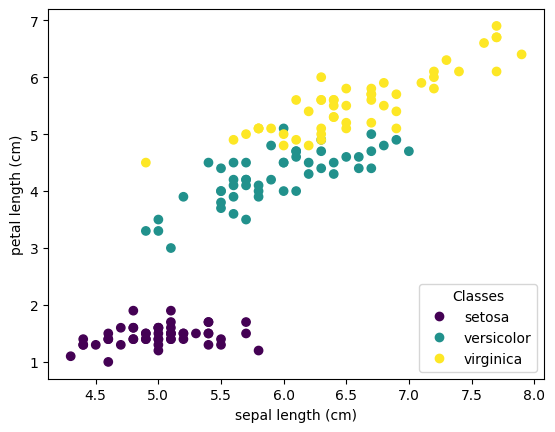

In [18]:
import matplotlib.pyplot as plt

_, ax = plt.subplots()
scatter = ax.scatter(iris.data[:, 0], iris.data[:, 2], c=iris.target)
ax.set(xlabel=iris.feature_names[0], ylabel=iris.feature_names[2])
_ = ax.legend(
    scatter.legend_elements()[0], iris.target_names, loc="lower right", title="Classes"
)


As you can see, we won't be able to find a perfect linear classifier if we try to classify Versicolor vs. Virginica. So let's do the following manipulations: 

- remove the Virginica samples
- remove the features corresponding to sepal and petal width
- create the vector of classes

In [19]:
# X is the feature array of shape (100, 2), first 50 elements are setosa
# sepal length and petal length, next 50 elements are Versicoloa sepal
# length and petal lemngth
X = iris.data[0:100, [0,2]]## YOUR CODE HERE ###

# y is the corresponding class vector, first 50 elements are +1 and last 50 elements are -1
y = iris.target[0:100] ### YOUR CODE HERE ###

In [6]:
print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


Now, make a scatter plot similar to the above but with the X and y arrays you just made, so we only see the Setosa and Versicolor samples.

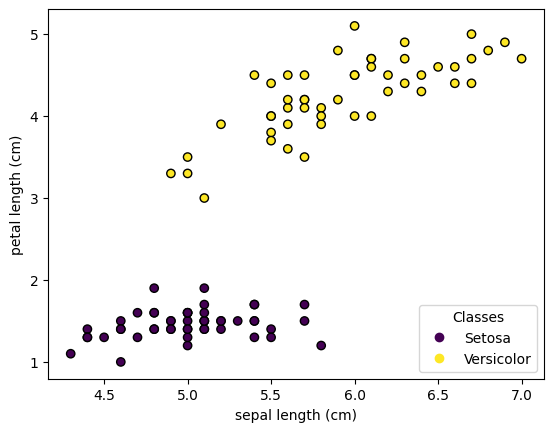

In [20]:
### YOUR CODE HERE ###
_, ax = plt.subplots()
scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k')

# Set labels
ax.set(xlabel=iris.feature_names[0], ylabel=iris.feature_names[2])

# Add legend for classes (Setosa and Versicolor)
_ = ax.legend(
    scatter.legend_elements()[0], 
    ['Setosa', 'Versicolor'], 
    loc="lower right", 
    title="Classes"
)

plt.show()

Let's finally run our Perceptron!

In [21]:
# Make the Perceptron and fit it
P = ### YOUR CODE HERE ###

# Inspect the weights, bias, and errors
w =  ### YOUR CODE HERE ###
b = ### YOUR CODE HERE ###
errors = ### YOUR CODE HERE ###

SyntaxError: invalid syntax (1409399157.py, line 2)

In [28]:
P = Perceptron(eta=0.1, n_iter=100)  # You can adjust the eta and n_iter values
P.fit(X, y)

# Inspect the weights, bias, and errors
w = P.w_    # Weights after fitting
b = P.b_  # Bias after fitting
errors = P.errors_

Now make a plot of the errors versus the passes over the data set

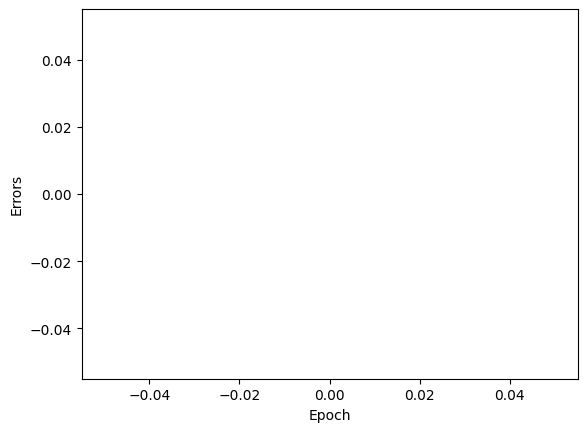

In [29]:
plt.plot(range(1, len(errors) + 1), errors, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Errors')
plt.show()

It'll be useful to have the following function which plots the decision boundaries of classifiers (no need to look carefully at this).

In [30]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))

    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=f'Class {cl}', 
                    edgecolor='black')

We'll use it with our trained Perceptron now.

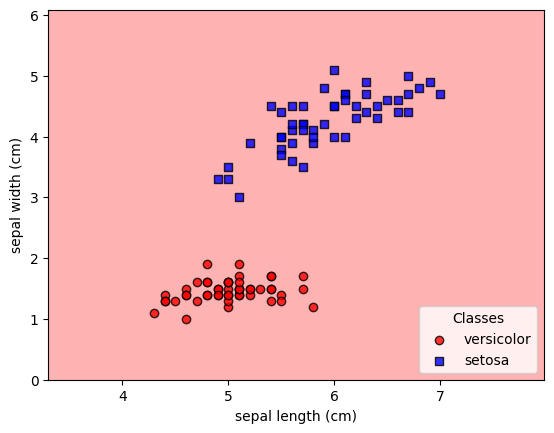

In [31]:
plot_decision_regions(X, y, classifier=P)
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.legend([iris.target_names[1], iris.target_names[0]], loc="lower right", title="Classes")
plt.show()

**You'll now implement a modified Perceptron, which accepts a kernel in the following manner.**

In [ ]:
def K_standard(u, v):
    return u.dot(v.T)

class KernelPerceptron:
    """ Kernel Perceptron classifier.

    Parameters
    ------------
    K : Kernel function
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    b_ : Scalar
      Bias unit after fitting.
    errors_ : list
      Number of misclassifications (updates) in each epoch.

    """
    def __init__(self, eta=1.0, n_iter=50, K = K_standard):
        self.eta = eta
        self.n_iter = n_iter
        self.K = K

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object
        
        """
        ### YOUR CODE HERE ###


        for _ in range(self.n_iter):
            errors = 0
            for k in range(0, self.n_):
                ### YOUR CODE HERE ###

            if errors == 0:
                return self
            
            self.errors_.append(errors)
            
        return self

    def net_input(self, X):
        """ Calculate net input """
        ### YOUR CODE HERE ###

    def predict(self, X):
        """ Return class label after unit step """
        return np.where(self.net_input(X) >= 0.0, 1, -1)

Let's check that the implementation works:

In [ ]:
KernelP_standard = KernelPerceptron()
KernelP_standard.fit(X, y)

plot_decision_regions(X, y, classifier=KernelP_standard)
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.legend([iris.target_names[1], iris.target_names[0]], loc="lower right", title="Classes")
plt.show()

You should recover the same plot as before.

** Let's now consider some data which can't be linearly classified. **

In [ ]:
from sklearn.datasets import make_circles

X_circle, y_circle = make_circles(n_samples = 200, factor=.5)
y_circle = 2*y_circle - 1 ## convert from 0-1 labels to -1 - 1 labels

_, ax = plt.subplots()
scatter = ax.scatter(X_circle[:, 0], X_circle[:, 1], c=y_circle)
#ax.set(xlabel=iris.feature_names[0], ylabel=iris.feature_names[2])
# plt.legend(["Inner circle", "Outer circle"], loc='upper-left', title="Classes")
# # _ = ax.legend(
# #     scatter.legend_elements()[0], loc="lower right", title="Classes"
# # )

What's a kernel that can linearly separate this data? Use the code we have developed above to fit a Kernel Perceptron which achieves perfect accuracy on this dataset, and visualize its decision regions on the circle data.

In [ ]:
def K_circle(u, v):
    ### YOUR CODE HERE ###

# Create and fit your Perceptron
KernelP_circle = ### YOUR CODE HERE ###


# Visualize the decision regions

plot_decision_regions(### YOUR CODE HERE ### )